In [4]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee

In [5]:
data = pd.read_table('LCdata.txt', sep='\s+', header = None, names=['time', 'flux'])
timeLC = data['time']
fluxLC = data['flux']
oot = np.abs(24.0*timeLC) >= 1.1 #points outside of transit
errorLC = np.std(fluxLC[oot])

In [10]:
## Planet properties
depth = 0.000174 #initial guess

period =  0.6892099 
ecc = 0.0
b = 0.5 

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

In [18]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    # Theta: Vector containing the variables listed above. 
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    #Below are the parameters entered in the previous window. 
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    # Redefinition of the LD coefficients with the parameters used in this function. 
    u1 = 0.5*(sumLD+diffLD) # u1 = 0.5*(u1+u2+(u1-u2)) = 0.5(2u1) = u1
    u2 = sumLD-u1 # u2 = (u1+u2)-u1 = u2
    
    #Use of the transit library. We will generate an artificial light curve with the parameters that we know 
    #and with those that we want to fit. 
    
    # First step: We use the "transit.System(transit.Central()))" module to create a planetary 'system' with a 
    #'central' bright star and a number N (>=0) of bodies in orbit. As the website notes, the default orbits of such
    # celestial objects are 100% Keplerian unless specified with subclasses. The parameters used to model the
    # 'central' star are the LD coefficients (mu1, mu2), its mass (pmass), and its radius (pradius). We have chosen
    # not to include the number of bodies in the system. 

    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    
    # Second step: We will use the "transit.Body" library to define the properties of our planet in the planetary system. 
    # The input parameters are the radius of the planet (r=Rp: this is calculated by taking the sqrt of
    # pdepth -- obtaining Rp/Rs -- and then multiplying by the radius of the star (pradius, which corresponds to Rs)
    # to obtain Rp), its period (given in the previous window), the time at which the transit occurs (t0 = pt0), the 
    # absolute value of the impact parameter, and the eccentricity (which we have also defined in the previous window.) 
    
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    
    # Third step: Add the planet to the system s. 
    s.add_body(body)
    
    # Fourth step: []
        # Question: Why do we need this?
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    # Fifth step: With the definitions of our planet and star, we create a theoretical curve and name it ftheo.
    # The input parameters are the times where the light curve should be evaluated in days (timeLC), the time of 
    # exposure (texp = tKep), the "stopping criterion for the exposure time integration" (t01=10^-8), and the 
    # "maximum depth of the exposure time integrator" (maxdepth).
    
        # Questions: How do we infer the values for tol and maxdepth? 
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    
    # Sixth Step: We subtract 1 and add the out of eclipse flux (f0) to our theoretical light curve.  
        #Question: Are we subtracting 1 to normalize the curve? Why is it important to add f0?
    
    ftheo = ftheo-1+f0
    
    # Seventh Step: Returns probability of the theoretical model to be the right model given the parameters that
    # characterize the star and the planet in our system.
    
        # Question: Don't really understand how this probability is calculated. 
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [20]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [21]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [15]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2675.866823
         Iterations: 593
         Function evaluations: 917


In [8]:
# Compute the light curve integrated over a Kepler long cadence
# exposure time.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

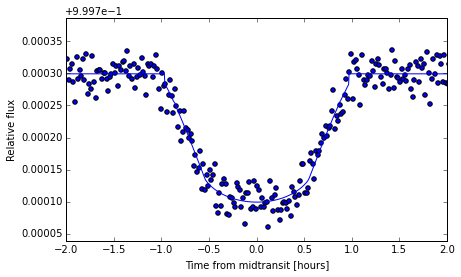

In [9]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

In [10]:
depth_ml, b_ml,  t0_ml, sigma_ml

(0.00017649681403018622,
 0.51840307890403792,
 0.00016879320948069183,
 6.266089468994943e-06)

In [11]:
ndim, nwalkers = 8, 100
pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(timeLC, fluxLC, errorLC, allfixed))
sampler.run_mcmc(pos, 5000)

In [ ]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

In [ ]:
import triangle
fig = triangle.corner(samples, labels=["$Depth$", "$b$", "$t0$", "sigma", "u1+u2", "M_s", "R_s", "f0"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [ ]:
samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

In [ ]:
planetrad_mcmc 

In [ ]:
r_a_mcmc